# Recognize Indian Currency by using Transfer Learning

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

root_dir = '/content/drive/My Drive/'
base_dir = '/content/drive/My Drive/datasets'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# !pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
os.listdir(base_dir)

['Leaf-Disease-Dataset',
 'APTOS-BlindnessDetection',
 'Digit-Recognizer-MNIST',
 'APTOS-interp',
 'CIFAR-10',
 'dogs-vs-cats-redux',
 'Flower-Dataset',
 'Indian-Currency-Dataset',
 'Viable_Non Seed',
 'BioSpeckle-Research']

## Setup Input Pipeline

In [0]:
# path_data = base_dir + '/Indian-Currency-Dataset/train/'
# path_test = base_dir + '/Indian-Currency-Dataset/test/'
path_train_cropped = base_dir + '/Indian-Currency-Dataset/train-cropped/'
path_valid_cropped = base_dir + '/Indian-Currency-Dataset/valid-cropped/'
path_test_cropped = base_dir + '/Indian-Currency-Dataset/test-cropped/'
path_scaled = base_dir + '/Indian-Currency-Dataset/scaled-images/'
path_aug = base_dir + '/Indian-Currency-Dataset/augmented_images/'

os.listdir(base_dir + '/Indian-Currency-Dataset/')

['test-cropped',
 'train-cropped',
 'valid-cropped',
 'notebooks',
 'scaled-images',
 'arr.npy']

In [0]:
IMAGE_SIZE = 360
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 180,
    # brightness_range=[0.8, 1.2],
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # fill_mode = 'constant',
    )

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(
    path_train_cropped,
    classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    seed = 10,
    # save_to_dir = path_aug,
    # save_prefix = 'tr-1',
    # save_format = 'jpg',
    batch_size = BATCH_SIZE)

val_generator = test_datagen.flow_from_directory(
    path_valid_cropped,
    classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    seed = 3)

test_generator = test_datagen.flow_from_directory(path_test_cropped,
                                                  classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
                                                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                  batch_size=BATCH_SIZE)

Found 9881 images belonging to 9 classes.
Found 2313 images belonging to 9 classes.
Found 294 images belonging to 9 classes.


In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights= 'imagenet')

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalMaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(9, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 2s 0us/step


In [0]:
base_model.trainable = False

In [0]:
# model.load_weights(path_train_cropped + '/save/fine_tuning/save-weights-3-top-mobnet.h5');

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics = ['categorical_accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 12, 12, 1280)      2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
activation (Activation)      (None, 512)               0

### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [0]:
epochs = 8

history = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/8
310/310 [==============================] - 6563s 21s/step - loss: 1.6668 - categorical_accuracy: 0.4900 - val_loss: 2.0679 - val_categorical_accuracy: 0.4855
Epoch 2/8
310/310 [==============================] - 336s 1s/step - loss: 1.2746 - categorical_accuracy: 0.5790 - val_loss: 1.7632 - val_categorical_accuracy: 0.4872
Epoch 3/8
310/310 [==============================] - 330s 1s/step - loss: 1.1269 - categorical_accuracy: 0.6111 - val_loss: 1.7125 - val_categorical_accuracy: 0.4838
Epoch 4/8
310/310 [==============================] - 337s 1s/step - loss: 1.0802 - categorical_accuracy: 0.6253 - val_loss: 1.5583 - val_categorical_accuracy: 0.5201
Epoch 5/8
310/310 [==============================] - 345s 1s/step - loss: 1.0328 - categorical_accuracy: 0.6436 - val_loss: 1.6754 - val_categorical_accuracy: 0.4829
Epoch 6/8
310/310 [==============================] - 346s 1s/step - loss: 1.0111 - categorical_accuracy: 0.6529 - val_loss: 1.5147 - val_categorical_accuracy: 0.5067
Ep

In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-1(1)-top-mobnet.h5')

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs = epochs,
                    validation_data = val_generator)

310/310 [==============================] - 352s 1s/step - loss: 0.9605 - categorical_accuracy: 0.6692 - val_loss: 1.5474 - val_categorical_accuracy: 0.5045


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-2-top-mobnet.h5')

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs = epochs,
                    validation_data = val_generator)

Epoch 1/5
635/635 [==============================] - 556s 876ms/step - loss: 1.1353 - categorical_accuracy: 0.6029 - val_loss: 1.7267 - val_categorical_accuracy: 0.4834
Epoch 2/5
635/635 [==============================] - 544s 856ms/step - loss: 1.1409 - categorical_accuracy: 0.6016 - val_loss: 1.8071 - val_categorical_accuracy: 0.4753
Epoch 3/5
635/635 [==============================] - 545s 859ms/step - loss: 1.1325 - categorical_accuracy: 0.6084 - val_loss: 1.6970 - val_categorical_accuracy: 0.4868
Epoch 4/5
635/635 [==============================] - 541s 852ms/step - loss: 1.1000 - categorical_accuracy: 0.6185 - val_loss: 1.7238 - val_categorical_accuracy: 0.4478
Epoch 5/5
635/635 [==============================] - 527s 829ms/step - loss: 1.1192 - categorical_accuracy: 0.6083 - val_loss: 1.4712 - val_categorical_accuracy: 0.5293


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-3-top-mobnet.h5')

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs = epochs,
                    validation_data = val_generator)

Epoch 1/5
276/276 [==============================] - 425s 2s/step - loss: 0.5540 - categorical_accuracy: 0.8207 - val_loss: 0.7490 - val_categorical_accuracy: 0.7796
Epoch 2/5
276/276 [==============================] - 423s 2s/step - loss: 0.4980 - categorical_accuracy: 0.8312 - val_loss: 0.8104 - val_categorical_accuracy: 0.7543
Epoch 3/5
276/276 [==============================] - 423s 2s/step - loss: 0.5042 - categorical_accuracy: 0.8353 - val_loss: 0.8499 - val_categorical_accuracy: 0.7635
Epoch 4/5
276/276 [==============================] - 424s 2s/step - loss: 0.4574 - categorical_accuracy: 0.8462 - val_loss: 0.8799 - val_categorical_accuracy: 0.7382
Epoch 5/5
276/276 [==============================] - 423s 2s/step - loss: 0.4525 - categorical_accuracy: 0.8491 - val_loss: 0.7113 - val_categorical_accuracy: 0.7842


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-2-ResNet-top.h5')

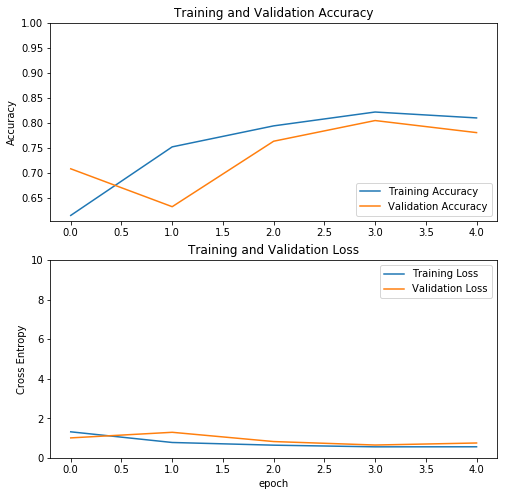

In [0]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
epochs = 40

history_1 = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/40
30/32 [===========================>..] - ETA: 2s - loss: 0.5543 - accuracy: 0.8525

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 58s 2s/step - loss: 0.5545 - accuracy: 0.8519 - val_loss: 4.2724 - val_accuracy: 0.3008
Epoch 2/40
32/32 [==============================] - 49s 2s/step - loss: 0.5564 - accuracy: 0.8428 - val_loss: 4.7080 - val_accuracy: 0.3171
Epoch 3/40
32/32 [==============================] - 49s 2s/step - loss: 0.4311 - accuracy: 0.8655 - val_loss: 5.3580 - val_accuracy: 0.2947
Epoch 4/40
32/32 [==============================] - 49s 2s/step - loss: 0.4088 - accuracy: 0.8705 - val_loss: 4.1000 - val_accuracy: 0.3516
Epoch 5/40
32/32 [==============================] - 49s 2s/step - loss: 0.3656 - accuracy: 0.8927 - val_loss: 5.6942 - val_accuracy: 0.3130
Epoch 6/40
32/32 [==============================] - 48s 2s/step - loss: 0.4129 - accuracy: 0.8670 - val_loss: 5.0287 - val_accuracy: 0.3130
Epoch 7/40
32/32 [==============================] - 48s 1s/step - loss: 0.3456 - accuracy: 0.8877 - val_loss: 4.8635 - val_accuracy: 0.3354
Epoch 8/40
32/32 [=============

In [0]:
model.save(path_data + '/save/fine_tuning/stage-2.h5')

In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-2.h5')

### Un-freeze the top layers of the model


In [0]:
# model.layers[0].trainable = True
# base_model.trainable = False
# model.load_weights(path_data + '/save/fine_tuning/saved-weights-10.h5')

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
model.load_weights(path_train_cropped + '/save/fine_tuning/save-weights-9(1)-from50-MobNet.h5')

### Compile the model

Compile the model using a much lower training rate.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(2e-5),
              metrics=['categorical_accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 12, 12, 1280)      2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
activation (Activation)      (None, 512)               0

### Continue Train the model

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 1,
                         validation_data=val_generator)

318/318 [==============================] - 6064s 19s/step - loss: 0.0246 - categorical_accuracy: 0.9933 - val_loss: 0.1339 - val_categorical_accuracy: 0.9624


In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 8,
                         validation_data=val_generator)

Epoch 1/8
310/310 [==============================] - 357s 1s/step - loss: 0.8476 - categorical_accuracy: 0.7087 - val_loss: 1.3612 - val_categorical_accuracy: 0.5573
Epoch 2/8
310/310 [==============================] - 348s 1s/step - loss: 0.7043 - categorical_accuracy: 0.7573 - val_loss: 1.0517 - val_categorical_accuracy: 0.6329
Epoch 3/8
310/310 [==============================] - 347s 1s/step - loss: 0.5919 - categorical_accuracy: 0.8034 - val_loss: 0.8719 - val_categorical_accuracy: 0.6969
Epoch 4/8
310/310 [==============================] - 343s 1s/step - loss: 0.4944 - categorical_accuracy: 0.8362 - val_loss: 0.8175 - val_categorical_accuracy: 0.7129
Epoch 5/8
310/310 [==============================] - 337s 1s/step - loss: 0.4349 - categorical_accuracy: 0.8537 - val_loss: 0.7385 - val_categorical_accuracy: 0.7402
Epoch 6/8
310/310 [==============================] - 336s 1s/step - loss: 0.3967 - categorical_accuracy: 0.8687 - val_loss: 0.6687 - val_categorical_accuracy: 0.7657
Epoc

In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-1(1)-from50-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 8,
                         validation_data=val_generator)

Epoch 1/8
310/310 [==============================] - 347s 1s/step - loss: 0.2928 - categorical_accuracy: 0.9079 - val_loss: 0.5123 - val_categorical_accuracy: 0.8310
Epoch 2/8
310/310 [==============================] - 330s 1s/step - loss: 0.2672 - categorical_accuracy: 0.9127 - val_loss: 0.4726 - val_categorical_accuracy: 0.8478
Epoch 3/8
310/310 [==============================] - 328s 1s/step - loss: 0.2403 - categorical_accuracy: 0.9261 - val_loss: 0.4493 - val_categorical_accuracy: 0.8565
Epoch 4/8
310/310 [==============================] - 327s 1s/step - loss: 0.2198 - categorical_accuracy: 0.9317 - val_loss: 0.4312 - val_categorical_accuracy: 0.8595
Epoch 5/8
310/310 [==============================] - 327s 1s/step - loss: 0.2098 - categorical_accuracy: 0.9394 - val_loss: 0.4312 - val_categorical_accuracy: 0.8578
Epoch 6/8
310/310 [==============================] - 325s 1s/step - loss: 0.1868 - categorical_accuracy: 0.9452 - val_loss: 0.4407 - val_categorical_accuracy: 0.8547
Epoc

In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-2(1)-from50-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
310/310 [==============================] - 338s 1s/step - loss: 0.1446 - categorical_accuracy: 0.9586 - val_loss: 0.4063 - val_categorical_accuracy: 0.8660
Epoch 2/5
310/310 [==============================] - 325s 1s/step - loss: 0.1369 - categorical_accuracy: 0.9610 - val_loss: 0.4038 - val_categorical_accuracy: 0.8738
Epoch 3/5
310/310 [==============================] - 330s 1s/step - loss: 0.1321 - categorical_accuracy: 0.9626 - val_loss: 0.3569 - val_categorical_accuracy: 0.8876
Epoch 4/5
310/310 [==============================] - 331s 1s/step - loss: 0.1323 - categorical_accuracy: 0.9647 - val_loss: 0.3652 - val_categorical_accuracy: 0.8850
Epoch 5/5
310/310 [==============================] - 326s 1s/step - loss: 0.1141 - categorical_accuracy: 0.9670 - val_loss: 0.3567 - val_categorical_accuracy: 0.8859


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-3(1)-from50-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
310/310 [==============================] - 342s 1s/step - loss: 0.1081 - categorical_accuracy: 0.9693 - val_loss: 0.3380 - val_categorical_accuracy: 0.8919
Epoch 2/5
310/310 [==============================] - 336s 1s/step - loss: 0.1022 - categorical_accuracy: 0.9702 - val_loss: 0.2915 - val_categorical_accuracy: 0.9070
Epoch 3/5
310/310 [==============================] - 330s 1s/step - loss: 0.0969 - categorical_accuracy: 0.9732 - val_loss: 0.2818 - val_categorical_accuracy: 0.9101
Epoch 4/5
310/310 [==============================] - 337s 1s/step - loss: 0.0901 - categorical_accuracy: 0.9743 - val_loss: 0.2758 - val_categorical_accuracy: 0.9148
Epoch 5/5
310/310 [==============================] - 331s 1s/step - loss: 0.0879 - categorical_accuracy: 0.9747 - val_loss: 0.2585 - val_categorical_accuracy: 0.9192


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-4(1)-from50-MobNet.h')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
310/310 [==============================] - 338s 1s/step - loss: 0.0828 - categorical_accuracy: 0.9779 - val_loss: 0.2258 - val_categorical_accuracy: 0.9300
Epoch 2/5
310/310 [==============================] - 330s 1s/step - loss: 0.0748 - categorical_accuracy: 0.9779 - val_loss: 0.2293 - val_categorical_accuracy: 0.9317
Epoch 3/5
310/310 [==============================] - 329s 1s/step - loss: 0.0752 - categorical_accuracy: 0.9804 - val_loss: 0.2230 - val_categorical_accuracy: 0.9343
Epoch 4/5
310/310 [==============================] - 332s 1s/step - loss: 0.0684 - categorical_accuracy: 0.9814 - val_loss: 0.2133 - val_categorical_accuracy: 0.9334
Epoch 5/5
310/310 [==============================] - 335s 1s/step - loss: 0.0605 - categorical_accuracy: 0.9832 - val_loss: 0.2278 - val_categorical_accuracy: 0.9269


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-5(1)-from50-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
310/310 [==============================] - 345s 1s/step - loss: 0.0600 - categorical_accuracy: 0.9832 - val_loss: 0.2390 - val_categorical_accuracy: 0.9248
Epoch 2/5
310/310 [==============================] - 336s 1s/step - loss: 0.0551 - categorical_accuracy: 0.9845 - val_loss: 0.2183 - val_categorical_accuracy: 0.9334
Epoch 3/5
310/310 [==============================] - 326s 1s/step - loss: 0.0474 - categorical_accuracy: 0.9868 - val_loss: 0.2391 - val_categorical_accuracy: 0.9265
Epoch 4/5
310/310 [==============================] - 333s 1s/step - loss: 0.0475 - categorical_accuracy: 0.9862 - val_loss: 0.2685 - val_categorical_accuracy: 0.9192
Epoch 5/5
310/310 [==============================] - 351s 1s/step - loss: 0.0374 - categorical_accuracy: 0.9906 - val_loss: 0.2425 - val_categorical_accuracy: 0.9261


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-6(1)-from50-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
310/310 [==============================] - 341s 1s/step - loss: 0.0372 - categorical_accuracy: 0.9900 - val_loss: 0.2467 - val_categorical_accuracy: 0.9222
Epoch 2/5
310/310 [==============================] - 324s 1s/step - loss: 0.0336 - categorical_accuracy: 0.9906 - val_loss: 0.2560 - val_categorical_accuracy: 0.9157
Epoch 3/5
310/310 [==============================] - 325s 1s/step - loss: 0.0304 - categorical_accuracy: 0.9922 - val_loss: 0.2156 - val_categorical_accuracy: 0.9317
Epoch 4/5
310/310 [==============================] - 326s 1s/step - loss: 0.0311 - categorical_accuracy: 0.9916 - val_loss: 0.2082 - val_categorical_accuracy: 0.9313
Epoch 5/5
310/310 [==============================] - 328s 1s/step - loss: 0.0287 - categorical_accuracy: 0.9917 - val_loss: 0.2019 - val_categorical_accuracy: 0.9343


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-7(1)-from50-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
310/310 [==============================] - 347s 1s/step - loss: 0.0288 - categorical_accuracy: 0.9916 - val_loss: 0.2044 - val_categorical_accuracy: 0.9326
Epoch 2/5
310/310 [==============================] - 334s 1s/step - loss: 0.0263 - categorical_accuracy: 0.9924 - val_loss: 0.1666 - val_categorical_accuracy: 0.9460
Epoch 3/5
310/310 [==============================] - 330s 1s/step - loss: 0.0242 - categorical_accuracy: 0.9933 - val_loss: 0.1380 - val_categorical_accuracy: 0.9542
Epoch 4/5
310/310 [==============================] - 324s 1s/step - loss: 0.0197 - categorical_accuracy: 0.9956 - val_loss: 0.1265 - val_categorical_accuracy: 0.9611
Epoch 5/5
310/310 [==============================] - 325s 1s/step - loss: 0.0191 - categorical_accuracy: 0.9950 - val_loss: 0.1239 - val_categorical_accuracy: 0.9607


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-8(1)-from120-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
309/309 [==============================] - 477s 2s/step - loss: 0.0201 - categorical_accuracy: 0.9944 - val_loss: 0.1246 - val_categorical_accuracy: 0.9589
Epoch 2/5
309/309 [==============================] - 490s 2s/step - loss: 0.0190 - categorical_accuracy: 0.9941 - val_loss: 0.1495 - val_categorical_accuracy: 0.9546
Epoch 3/5
309/309 [==============================] - 513s 2s/step - loss: 0.0172 - categorical_accuracy: 0.9951 - val_loss: 0.1453 - val_categorical_accuracy: 0.9524
Epoch 4/5
309/309 [==============================] - 523s 2s/step - loss: 0.0176 - categorical_accuracy: 0.9942 - val_loss: 0.1445 - val_categorical_accuracy: 0.9589
Epoch 5/5
309/309 [==============================] - 546s 2s/step - loss: 0.0149 - categorical_accuracy: 0.9960 - val_loss: 0.1265 - val_categorical_accuracy: 0.9637


In [0]:
# model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-9(1)-from50-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,    
                         validation_data=val_generator)

Epoch 1/5
309/309 [==============================] - 576s 2s/step - loss: 0.0117 - categorical_accuracy: 0.9970 - val_loss: 0.1461 - val_categorical_accuracy: 0.9576
Epoch 2/5
309/309 [==============================] - 577s 2s/step - loss: 0.0100 - categorical_accuracy: 0.9976 - val_loss: 0.1552 - val_categorical_accuracy: 0.9559
Epoch 3/5
309/309 [==============================] - 611s 2s/step - loss: 0.0116 - categorical_accuracy: 0.9973 - val_loss: 0.1563 - val_categorical_accuracy: 0.9486
Epoch 4/5
309/309 [==============================] - 576s 2s/step - loss: 0.0117 - categorical_accuracy: 0.9970 - val_loss: 0.1461 - val_categorical_accuracy: 0.9576
Epoch 2/5
309/309 [==============================] - 577s 2s/step - loss: 0.0100 - categorical_accuracy: 0.9976 - val_loss: 0.1552 - val_categorical_accuracy: 0.9559
Epoch 3/5
309/309 [==============================] - 611s 2s/step - loss: 0.0116 - categorical_accuracy: 0.9973 - val_loss: 0.1563 - val_categorical_accuracy: 0.9486
Epoc

In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-10(1)-from50-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
309/309 [==============================] - 756s 2s/step - loss: 0.0091 - categorical_accuracy: 0.9979 - val_loss: 0.1311 - val_categorical_accuracy: 0.9633
Epoch 2/5
309/309 [==============================] - 799s 3s/step - loss: 0.0088 - categorical_accuracy: 0.9973 - val_loss: 0.1485 - val_categorical_accuracy: 0.9568
Epoch 3/5
309/309 [==============================] - 835s 3s/step - loss: 0.0085 - categorical_accuracy: 0.9977 - val_loss: 0.1338 - val_categorical_accuracy: 0.9602
Epoch 4/5
309/309 [==============================] - 849s 3s/step - loss: 0.0069 - categorical_accuracy: 0.9981 - val_loss: 0.1293 - val_categorical_accuracy: 0.9594
Epoch 5/5
309/309 [==============================] - 981s 3s/step - loss: 0.0089 - categorical_accuracy: 0.9978 - val_loss: 0.1639 - val_categorical_accuracy: 0.9477


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-10-from120-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 416s 2s/step - loss: 0.3013 - categorical_accuracy: 0.9063 - val_loss: 0.9068 - val_categorical_accuracy: 0.6866
Epoch 2/5
276/276 [==============================] - 415s 2s/step - loss: 0.2973 - categorical_accuracy: 0.9063 - val_loss: 0.8772 - val_categorical_accuracy: 0.6889
Epoch 3/5
276/276 [==============================] - 421s 2s/step - loss: 0.2846 - categorical_accuracy: 0.9138 - val_loss: 0.8451 - val_categorical_accuracy: 0.7061
Epoch 4/5
276/276 [==============================] - 421s 2s/step - loss: 0.2769 - categorical_accuracy: 0.9074 - val_loss: 0.8584 - val_categorical_accuracy: 0.6969
Epoch 5/5
276/276 [==============================] - 423s 2s/step - loss: 0.2800 - categorical_accuracy: 0.9095 - val_loss: 0.8747 - val_categorical_accuracy: 0.6912


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-11-from120-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 499s 2s/step - loss: 0.2636 - categorical_accuracy: 0.9126 - val_loss: 0.8960 - val_categorical_accuracy: 0.6808
Epoch 2/5
276/276 [==============================] - 497s 2s/step - loss: 0.2572 - categorical_accuracy: 0.9192 - val_loss: 0.7376 - val_categorical_accuracy: 0.7325
Epoch 3/5
276/276 [==============================] - 469s 2s/step - loss: 0.2467 - categorical_accuracy: 0.9224 - val_loss: 0.6879 - val_categorical_accuracy: 0.7566
Epoch 4/5
276/276 [==============================] - 501s 2s/step - loss: 0.2411 - categorical_accuracy: 0.9199 - val_loss: 0.6617 - val_categorical_accuracy: 0.7761
Epoch 5/5
276/276 [==============================] - 517s 2s/step - loss: 0.2256 - categorical_accuracy: 0.9253 - val_loss: 0.6825 - val_categorical_accuracy: 0.7646


In [0]:
#from 110
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-12-from120-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 1607s 6s/step - loss: 0.2442 - categorical_accuracy: 0.9192 - val_loss: 0.6234 - val_categorical_accuracy: 0.7830
Epoch 2/5
276/276 [==============================] - 225s 816ms/step - loss: 0.2164 - categorical_accuracy: 0.9319 - val_loss: 0.6399 - val_categorical_accuracy: 0.7773
Epoch 3/5
276/276 [==============================] - 224s 813ms/step - loss: 0.2090 - categorical_accuracy: 0.9315 - val_loss: 0.6024 - val_categorical_accuracy: 0.7945
Epoch 4/5
276/276 [==============================] - 225s 814ms/step - loss: 0.2194 - categorical_accuracy: 0.9265 - val_loss: 0.6457 - val_categorical_accuracy: 0.7704
Epoch 5/5
276/276 [==============================] - 224s 811ms/step - loss: 0.1936 - categorical_accuracy: 0.9371 - val_loss: 0.5843 - val_categorical_accuracy: 0.7979


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-13-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 234s 847ms/step - loss: 0.1875 - categorical_accuracy: 0.9426 - val_loss: 0.5278 - val_categorical_accuracy: 0.8232
Epoch 2/5
276/276 [==============================] - 223s 809ms/step - loss: 0.1892 - categorical_accuracy: 0.9403 - val_loss: 0.5063 - val_categorical_accuracy: 0.8232
Epoch 3/5
276/276 [==============================] - 224s 810ms/step - loss: 0.1831 - categorical_accuracy: 0.9403 - val_loss: 0.4652 - val_categorical_accuracy: 0.8439
Epoch 4/5
276/276 [==============================] - 223s 808ms/step - loss: 0.1866 - categorical_accuracy: 0.9378 - val_loss: 0.4397 - val_categorical_accuracy: 0.8519
Epoch 5/5
276/276 [==============================] - 223s 808ms/step - loss: 0.1863 - categorical_accuracy: 0.9421 - val_loss: 0.5485 - val_categorical_accuracy: 0.8152


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-14-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 231s 838ms/step - loss: 0.1695 - categorical_accuracy: 0.9440 - val_loss: 0.5182 - val_categorical_accuracy: 0.8186
Epoch 2/5
276/276 [==============================] - 227s 823ms/step - loss: 0.1555 - categorical_accuracy: 0.9505 - val_loss: 0.5208 - val_categorical_accuracy: 0.8048
Epoch 3/5
276/276 [==============================] - 226s 820ms/step - loss: 0.1713 - categorical_accuracy: 0.9480 - val_loss: 0.5610 - val_categorical_accuracy: 0.7945
Epoch 4/5
276/276 [==============================] - 227s 823ms/step - loss: 0.1583 - categorical_accuracy: 0.9530 - val_loss: 0.5591 - val_categorical_accuracy: 0.7956
Epoch 5/5
276/276 [==============================] - 223s 809ms/step - loss: 0.1444 - categorical_accuracy: 0.9535 - val_loss: 0.4698 - val_categorical_accuracy: 0.8347


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-15-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 2,
                         validation_data=val_generator)

Epoch 1/2
276/276 [==============================] - 235s 852ms/step - loss: 0.1471 - categorical_accuracy: 0.9542 - val_loss: 0.4788 - val_categorical_accuracy: 0.8289
Epoch 2/2
276/276 [==============================] - 222s 805ms/step - loss: 0.1432 - categorical_accuracy: 0.9526 - val_loss: 0.4088 - val_categorical_accuracy: 0.8645


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-15-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 2,
                         validation_data=val_generator)

Epoch 1/2
276/276 [==============================] - 232s 841ms/step - loss: 0.1461 - categorical_accuracy: 0.9528 - val_loss: 0.4150 - val_categorical_accuracy: 0.8760
Epoch 2/2
276/276 [==============================] - 222s 805ms/step - loss: 0.1346 - categorical_accuracy: 0.9605 - val_loss: 0.3338 - val_categorical_accuracy: 0.8921


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-16-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 1620s 6s/step - loss: 0.1245 - categorical_accuracy: 0.9632 - val_loss: 0.3688 - val_categorical_accuracy: 0.8772
Epoch 2/5
276/276 [==============================] - 230s 832ms/step - loss: 0.1212 - categorical_accuracy: 0.9626 - val_loss: 0.3800 - val_categorical_accuracy: 0.8760
Epoch 3/5
276/276 [==============================] - 232s 840ms/step - loss: 0.1237 - categorical_accuracy: 0.9612 - val_loss: 0.3257 - val_categorical_accuracy: 0.8944
Epoch 4/5
276/276 [==============================] - 226s 819ms/step - loss: 0.1307 - categorical_accuracy: 0.9582 - val_loss: 0.3625 - val_categorical_accuracy: 0.8852
Epoch 5/5
276/276 [==============================] - 235s 852ms/step - loss: 0.1296 - categorical_accuracy: 0.9594 - val_loss: 0.3727 - val_categorical_accuracy: 0.8794


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-17-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 231s 835ms/step - loss: 0.1081 - categorical_accuracy: 0.9666 - val_loss: 0.4127 - val_categorical_accuracy: 0.8565
Epoch 2/5
276/276 [==============================] - 228s 827ms/step - loss: 0.1014 - categorical_accuracy: 0.9687 - val_loss: 0.4062 - val_categorical_accuracy: 0.8726
Epoch 3/5
276/276 [==============================] - 225s 815ms/step - loss: 0.1072 - categorical_accuracy: 0.9671 - val_loss: 0.4151 - val_categorical_accuracy: 0.8691
Epoch 4/5
276/276 [==============================] - 225s 814ms/step - loss: 0.0970 - categorical_accuracy: 0.9671 - val_loss: 0.3893 - val_categorical_accuracy: 0.8749
Epoch 5/5
276/276 [==============================] - 232s 842ms/step - loss: 0.1077 - categorical_accuracy: 0.9641 - val_loss: 0.3101 - val_categorical_accuracy: 0.9001


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-18-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
635/635 [==============================] - 3234s 5s/step - loss: 0.3074 - categorical_accuracy: 0.9094 - val_loss: 0.3883 - val_categorical_accuracy: 0.8783
Epoch 2/5
635/635 [==============================] - 707s 1s/step - loss: 0.2170 - categorical_accuracy: 0.9367 - val_loss: 0.4051 - val_categorical_accuracy: 0.8668
Epoch 3/5
635/635 [==============================] - 735s 1s/step - loss: 0.1889 - categorical_accuracy: 0.9409 - val_loss: 0.4300 - val_categorical_accuracy: 0.8622
Epoch 4/5
635/635 [==============================] - 764s 1s/step - loss: 0.1645 - categorical_accuracy: 0.9521 - val_loss: 0.4564 - val_categorical_accuracy: 0.8565
Epoch 5/5
635/635 [==============================] - 778s 1s/step - loss: 0.1590 - categorical_accuracy: 0.9504 - val_loss: 0.3758 - val_categorical_accuracy: 0.8806


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-19-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
635/635 [==============================] - 534s 841ms/step - loss: 0.1435 - categorical_accuracy: 0.9562 - val_loss: 0.3447 - val_categorical_accuracy: 0.8898
Epoch 2/5
635/635 [==============================] - 517s 815ms/step - loss: 0.1311 - categorical_accuracy: 0.9578 - val_loss: 0.3315 - val_categorical_accuracy: 0.8955
Epoch 3/5
635/635 [==============================] - 516s 813ms/step - loss: 0.1234 - categorical_accuracy: 0.9627 - val_loss: 0.3654 - val_categorical_accuracy: 0.8783
Epoch 4/5
635/635 [==============================] - 518s 816ms/step - loss: 0.1176 - categorical_accuracy: 0.9633 - val_loss: 0.3144 - val_categorical_accuracy: 0.9013
Epoch 5/5
635/635 [==============================] - 521s 821ms/step - loss: 0.1029 - categorical_accuracy: 0.9697 - val_loss: 0.3261 - val_categorical_accuracy: 0.8863


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-20-from100.-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
635/635 [==============================] - 532s 837ms/step - loss: 0.0983 - categorical_accuracy: 0.9688 - val_loss: 0.3248 - val_categorical_accuracy: 0.8898
Epoch 2/5
635/635 [==============================] - 527s 829ms/step - loss: 0.1014 - categorical_accuracy: 0.9678 - val_loss: 0.3016 - val_categorical_accuracy: 0.8990
Epoch 3/5
635/635 [==============================] - 521s 821ms/step - loss: 0.0917 - categorical_accuracy: 0.9710 - val_loss: 0.2977 - val_categorical_accuracy: 0.9059
Epoch 4/5
635/635 [==============================] - 516s 813ms/step - loss: 0.0890 - categorical_accuracy: 0.9712 - val_loss: 0.2764 - val_categorical_accuracy: 0.9059
Epoch 5/5
635/635 [==============================] - 532s 838ms/step - loss: 0.0779 - categorical_accuracy: 0.9761 - val_loss: 0.3243 - val_categorical_accuracy: 0.8886


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-21-from100.-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
635/635 [==============================] - 558s 879ms/step - loss: 0.0820 - categorical_accuracy: 0.9735 - val_loss: 0.2530 - val_categorical_accuracy: 0.9208
Epoch 2/5
635/635 [==============================] - 544s 857ms/step - loss: 0.0798 - categorical_accuracy: 0.9737 - val_loss: 0.2654 - val_categorical_accuracy: 0.9185
Epoch 3/5
635/635 [==============================] - 547s 861ms/step - loss: 0.0734 - categorical_accuracy: 0.9778 - val_loss: 0.2533 - val_categorical_accuracy: 0.9162
Epoch 4/5
635/635 [==============================] - 549s 864ms/step - loss: 0.0665 - categorical_accuracy: 0.9796 - val_loss: 0.2530 - val_categorical_accuracy: 0.9093
Epoch 5/5
635/635 [==============================] - 530s 834ms/step - loss: 0.0735 - categorical_accuracy: 0.9772 - val_loss: 0.3243 - val_categorical_accuracy: 0.8921


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-22-from100.-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 228s 827ms/step - loss: 0.0537 - categorical_accuracy: 0.9848 - val_loss: 0.3070 - val_categorical_accuracy: 0.9013
Epoch 2/5
276/276 [==============================] - 227s 823ms/step - loss: 0.0524 - categorical_accuracy: 0.9846 - val_loss: 0.3132 - val_categorical_accuracy: 0.9024
Epoch 3/5
276/276 [==============================] - 226s 818ms/step - loss: 0.0536 - categorical_accuracy: 0.9828 - val_loss: 0.3498 - val_categorical_accuracy: 0.8898
Epoch 4/5
276/276 [==============================] - 226s 819ms/step - loss: 0.0579 - categorical_accuracy: 0.9807 - val_loss: 0.2882 - val_categorical_accuracy: 0.9059
Epoch 5/5
276/276 [==============================] - 226s 820ms/step - loss: 0.0498 - categorical_accuracy: 0.9853 - val_loss: 0.2907 - val_categorical_accuracy: 0.9104


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-23-from100.-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 232s 839ms/step - loss: 0.0506 - categorical_accuracy: 0.9855 - val_loss: 0.3813 - val_categorical_accuracy: 0.8737
Epoch 2/5
276/276 [==============================] - 227s 822ms/step - loss: 0.0517 - categorical_accuracy: 0.9841 - val_loss: 0.3862 - val_categorical_accuracy: 0.8668
Epoch 3/5
276/276 [==============================] - 224s 810ms/step - loss: 0.0466 - categorical_accuracy: 0.9873 - val_loss: 0.3493 - val_categorical_accuracy: 0.8852
Epoch 4/5
276/276 [==============================] - 227s 822ms/step - loss: 0.0451 - categorical_accuracy: 0.9882 - val_loss: 0.4071 - val_categorical_accuracy: 0.8588
Epoch 5/5
276/276 [==============================] - 228s 826ms/step - loss: 0.0485 - categorical_accuracy: 0.9855 - val_loss: 0.4041 - val_categorical_accuracy: 0.8588


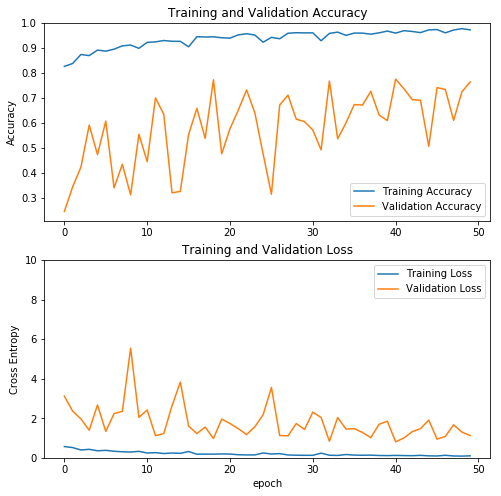

In [0]:
acc = history_fine.history['categorical_accuracy']
val_acc = history_fine.history['val_categorical_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs = 10,
                         validation_data=val_generator)

Epoch 1/10
262/262 [==============================] - 551s 2s/step - loss: 0.0718 - categorical_accuracy: 0.9763 - val_loss: 3.2012 - val_categorical_accuracy: 0.6750
Epoch 2/10
262/262 [==============================] - 533s 2s/step - loss: 0.0962 - categorical_accuracy: 0.9723 - val_loss: 2.0268 - val_categorical_accuracy: 0.6788
Epoch 3/10
262/262 [==============================] - 525s 2s/step - loss: 0.0721 - categorical_accuracy: 0.9782 - val_loss: 3.0902 - val_categorical_accuracy: 0.6308
Epoch 4/10
262/262 [==============================] - 514s 2s/step - loss: 0.0666 - categorical_accuracy: 0.9792 - val_loss: 2.0423 - val_categorical_accuracy: 0.7202
Epoch 5/10
262/262 [==============================] - 536s 2s/step - loss: 0.0650 - categorical_accuracy: 0.9813 - val_loss: 1.1903 - val_categorical_accuracy: 0.7933
Epoch 6/10
262/262 [==============================] - 509s 2s/step - loss: 0.0813 - categorical_accuracy: 0.9739 - val_loss: 2.3755 - val_categorical_accuracy: 0.697

In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-2-from2.h5')

#Testing

In [0]:
model.evaluate(test_generator)

19/19 [==============================] - 79s 4s/step - loss: 5.4265 - categorical_accuracy: 0.1701


[5.426527675829436, 0.17006803]

In [0]:
from sklearn.utils.multiclass import unique_labels

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.BrBG):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

###On Train

318/318 [==============================] - 4269s 13s/step
[[ 777    1    2    7    1    0    0    7    1]
 [  11 1093    0    2    8    0    0    2    9]
 [   7    0 1122   16    8    0    0   25    3]
 [  12    0    0 1054    0    0    0    0    1]
 [  19    0    1    3 1150    1    0    0    0]
 [  10    0    4    3   43 1102    0   32   20]
 [  11    0    5    1    0    0 1035   15   52]
 [   3    0    1    0    0    0    0 1184    6]
 [  16    0    0    2    0    0    0    0 1266]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       796
           1       1.00      0.97      0.99      1125
           2       0.99      0.95      0.97      1181
           3       0.97      0.99      0.98      1067
           4       0.95      0.98      0.96      1174
           5       1.00      0.91      0.95      1214
           6       1.00      0.92      0.96      1119
           7       0.94      0.99      0.96      1194
           8       0.9

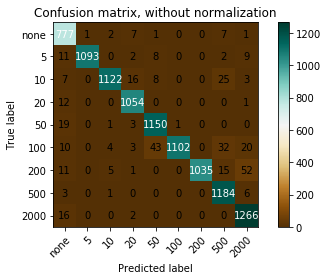

In [0]:
train_generator.shuffle = False
Y_pred = model.predict_generator(train_generator, verbose = 1)
y_pred = np.argmax(Y_pred, axis = 1)
print(confusion_matrix(train_generator.classes[train_generator.index_array], y_pred))
print(classification_report(train_generator.classes[train_generator.index_array], y_pred))
plot_confusion_matrix(train_generator.classes[train_generator.index_array], y_pred, np.array(['none', '5', '10', '20', '50', '100', '200', '500', '2000']), False)

###On Validation

In [0]:
val_generator.shuffle = False

73/73 [==============================] - 17s 229ms/step
Confusion matrix, without normalization
[[123   1   0   0   0   0   0   0   0]
 [  0  85   4   0   2   0   0   0   1]
 [  4   0 264   5   2   0   0   3   0]
 [  5   0   0 255   0   0   0   0   0]
 [  0   0   0   0 342   0   0   0   1]
 [  2   0   1   1  22 273   0   8   6]
 [  0   0   1   0   0   0 282   1   2]
 [  2   0   1   0   0   0   0 300   1]
 [  6   0   0   1   0   0   0   0 306]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       124
           1       0.99      0.92      0.96        92
           2       0.97      0.95      0.96       278
           3       0.97      0.98      0.98       260
           4       0.93      1.00      0.96       343
           5       1.00      0.87      0.93       313
           6       1.00      0.99      0.99       286
           7       0.96      0.99      0.97       304
           8       0.97      0.98      0.97       313

    accura

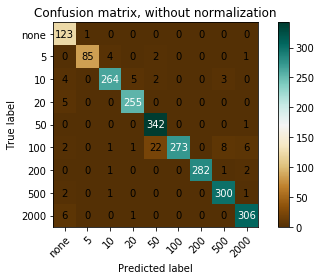

In [0]:
Y_pred = model.predict_generator(val_generator, verbose = 1)
y_pred = np.argmax(Y_pred, axis = 1)
plot_confusion_matrix(val_generator.classes[val_generator.index_array], y_pred, np.array(['none', '5', '10', '20', '50', '100', '200', '500', '2000']), False)
print(classification_report(val_generator.classes[val_generator.index_array], y_pred))

###On Test

10/10 [==============================] - 154s 15s/step
Confusion matrix, without normalization
[[15  0  3  3  1  0  4  1  2]
 [ 1 23  0  0  0  0  0  0  0]
 [22  1 29  3  2  0  0  0  0]
 [ 1  0  0  9  0  0  0  0  0]
 [ 1  0  0  0 41  0  0  0  0]
 [14  1  5  2  5 20  0 15  0]
 [ 1  0  2  1  0  0 35  0  4]
 [ 0  0  0  0  0  0  0 22  0]
 [ 0  0  0  0  0  0  0  0  5]]
              precision    recall  f1-score   support

           0       0.27      0.52      0.36        29
           1       0.92      0.96      0.94        24
           2       0.74      0.51      0.60        57
           3       0.50      0.90      0.64        10
           4       0.84      0.98      0.90        42
           5       1.00      0.32      0.49        62
           6       0.90      0.81      0.85        43
           7       0.58      1.00      0.73        22
           8       0.45      1.00      0.62         5

    accuracy                           0.68       294
   macro avg       0.69      0.78     

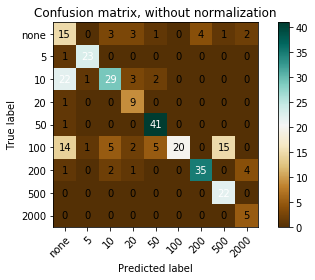

In [0]:
test_generator.shuffle = False
Y_pred = model.predict_generator(test_generator, verbose = 1)
y_pred = np.argmax(Y_pred, axis = 1)
plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, np.array(['none', '5', '10', '20', '50', '100', '200', '500', '2000']), False)
print(classification_report(test_generator.classes[test_generator.index_array], y_pred))

# Interpretation

388800


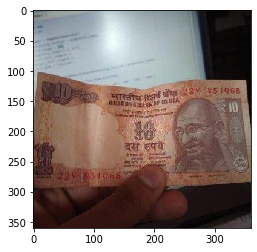

In [0]:
img_path = path_train_cropped + '/10/10_kj_6.jpg'
im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
# im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
print(im.size)
plt.imshow(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


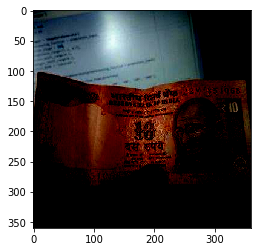

In [0]:
im_1 = preprocess_input(im)
plt.imshow(im_1)

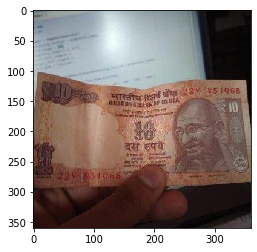

In [0]:
im_2 = im / 255.
plt.imshow(im_2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


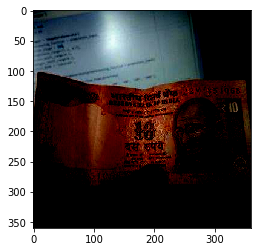

In [0]:
im_3 = (im - 127.5) / 127.5
plt.imshow(im_3)

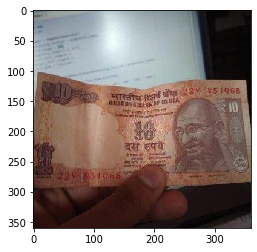

In [0]:
plt.imshow(im)

In [0]:
im = np.expand_dims(im, 0)
im.shape

(1, 360, 360, 3)

In [0]:
im = im.astype(np.float32)
im.dtype

dtype('float32')

In [0]:
pred = model.predict(im)
pred = np.argmax(pred, 1)[0]
pred

0

In [0]:
classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000']

In [0]:
classes[pred] != 'none'

False

In [0]:
path =  path_train_cropped + '/none/'
name  = '10_sj_4.jpg'

In [0]:
path_img = os.path.join(path, name)
im = cv2.imread(path_img)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = preprocess_input(im)
im = np.expand_dims(im, 0)
pred = model.predict(im)
pred = np.argmax(pred, 1)[0]
int(classes[pred])

10

In [0]:
def show_errors(path, true, model):
  img_names = os.listdir(path)
  classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000']
  error_images = []
  wrong_labels = []
  probs = []
  for img_name in tqdm(img_names):
    path_img = os.path.join(path, img_name)
    im = cv2.imread(path_img)
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     im = preprocess_input(im)
    im = (im) / 127.5
    im = np.expand_dims(im, 0).astype(np.float32)
    pred = model.predict(im)
    prob = np.max(pred, 1)[0]
    pred = np.argmax(pred, 1)[0]
    pred = classes[pred]

    if pred != true:
      error_images.append(img_name)
      wrong_labels.append(pred)
      probs.append(prob)
    
  return (error_images, wrong_labels, probs)

In [0]:
def plot_errors(wrong_labels, path, error_images, probs, rows):
  fig = plt.figure(figsize = (32, 32))
  total_images = len(error_images)
  rows = rows
  cols = (total_images//rows) + 1
  for i in range(total_images):
    img_name = error_images[i]
    wrong_label = wrong_labels[i]
    prob = probs[i]
    path_img = os.path.join(path, img_name)
    # print(path_img)
    im = cv2.imread(path_img)
    # print(im)
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = preprocess_input(im)
    # im = (im - 127.5) / 127.5
    fig.add_subplot(rows, cols, i+1)
    plt.title(wrong_label + '/' + str(prob))
    plt.imshow(im)

In [0]:
def print_probs(path, model):
  classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000']
  im = cv2.imread(path)
  im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = preprocess_input(im)
  # im = (im - 127.5) / 127.5
  plt.imshow(im)
  im = np.expand_dims(im, 0).astype(np.float32)
  pred = model.predict(im)

  dic = {k:v for (k, v) in zip(classes, pred[0])}
  for key, value in sorted(dic.items(), key=lambda kv: kv[1], reverse=True):
      print("%s --> %s" % (key, value))

In [0]:
folder = '10'
path = f'/content/drive/My Drive/datasets/Indian-Currency-Dataset/valid-cropped/{folder}/'
error_images, wrong_labels, probs = show_errors(path, folder, model)

100%|██████████| 278/278 [00:15<00:00, 18.31it/s]


In [0]:
freq = {'none' : 0, '5' : 0, '10' : 0, '20' : 0, '50' : 0, '100' : 0, '200' : 0, '500' : 0, '2000' : 0}
for label in wrong_labels:
  freq[label] += 1

freq

{'10': 0,
 '100': 0,
 '20': 4,
 '200': 0,
 '2000': 0,
 '5': 0,
 '50': 1,
 '500': 6,
 'none': 5}

In [0]:
freq = {'none' : 0, '5' : 0, '10' : 0, '20' : 0, '50' : 0, '100' : 0, '200' : 0, '500' : 0, '2000' : 0}
for label in wrong_labels:
  freq[label] += 1

freq

{'10': 0,
 '100': 0,
 '20': 39,
 '200': 0,
 '2000': 0,
 '5': 0,
 '50': 5,
 '500': 21,
 'none': 56}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

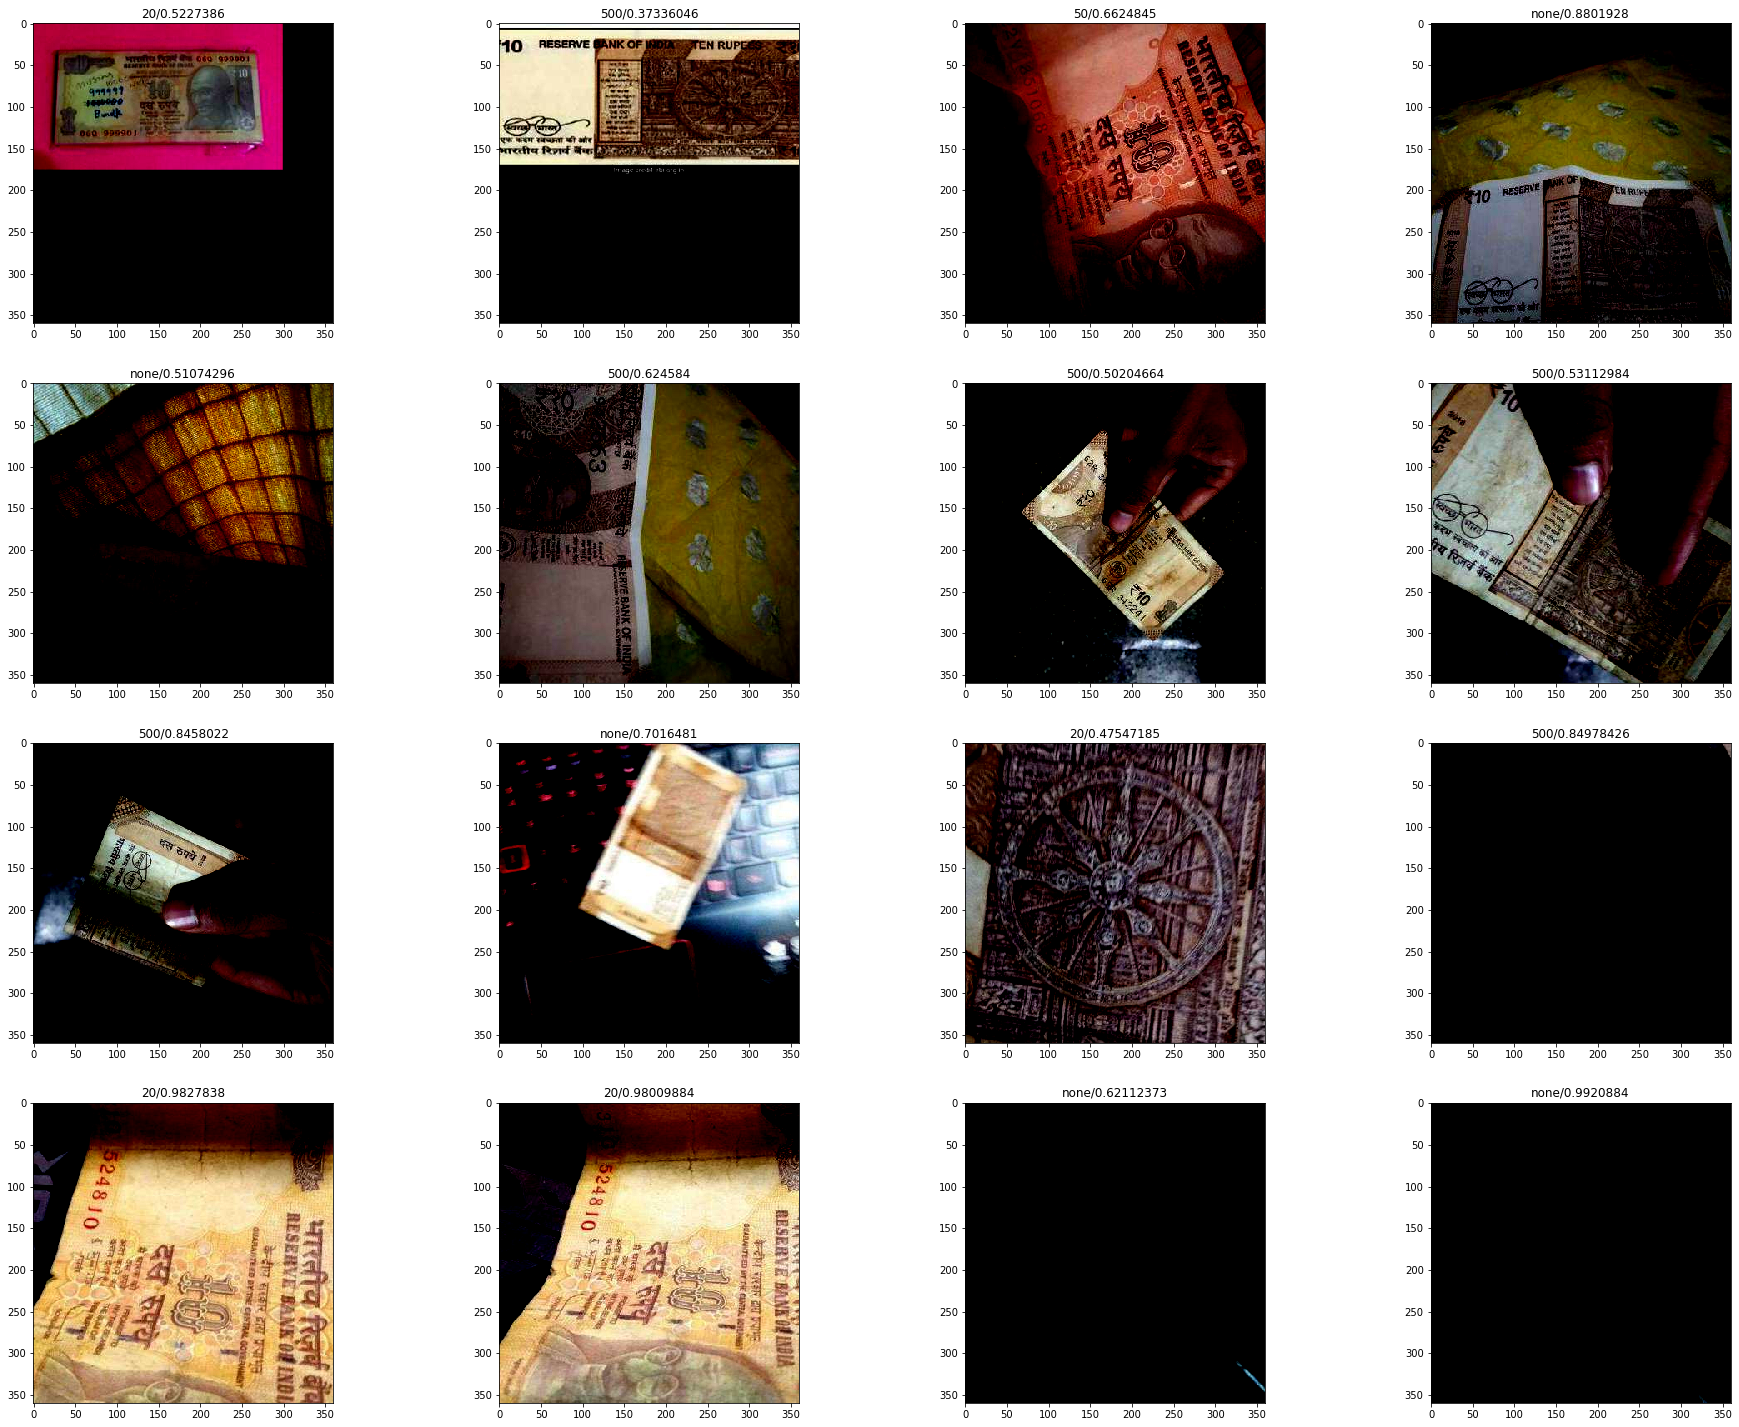

In [0]:
plot_errors(wrong_labels, path, error_images, probs, 5)

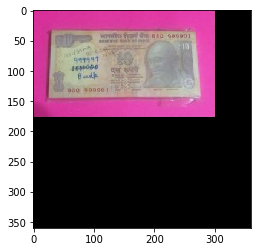

In [0]:
im = cv2.imread('/content/drive/My Drive/datasets/Indian-Currency-Dataset/valid-cropped/10/10_13.jpg')
im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
# im = np.expand_dims(im, 0).astype(np.float32)
# im = preprocess_input(im)
plt.imshow(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


none --> 0.99208844
500 --> 0.005094959
20 --> 0.0010206061
2000 --> 0.00071698683
50 --> 0.00062771316
100 --> 0.00025491026
5 --> 9.068906e-05
10 --> 8.04689e-05
200 --> 2.5202542e-05


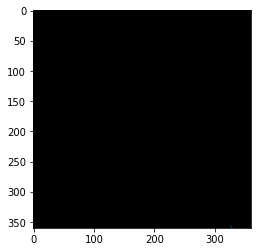

In [0]:
i = len(error_images) - 8
path = os.path.join(path_valid_cropped, folder, error_images[i])
print_probs(path, model)

###Saving preprocessed image

In [0]:
import PIL
from matplotlib import cm
import skimage.io

In [0]:
folder = '10'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


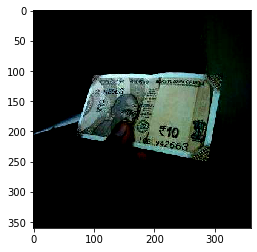

In [0]:
path_folder = os.path.join(path_train_cropped, folder)
image_names = os.listdir(path_folder)
img_path = os.path.join(path_folder, image_names[2])

im = skimage.io.imread(img_path)
# im = cv2.imread(img_path)
# im = PIL.Image.open(img_path)
# im = np.array(im)
# im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = preprocess_input(im)
plt.imshow(im)

In [0]:
np.round()

Array([[[ 43.,  28.,  31.],
        [ 44.,  30.,  30.],
        [ 45.,  31.,  31.],
        ...,
        [151., 160., 155.],
        [149., 158., 153.],
        [146., 155., 150.]],

       [[ 43.,  28.,  31.],
        [ 44.,  30.,  30.],
        [ 45.,  31.,  31.],
        ...,
        [150., 160., 152.],
        [149., 159., 151.],
        [148., 158., 150.]],

       [[ 43.,  28.,  31.],
        [ 44.,  30.,  30.],
        [ 45.,  31.,  31.],
        ...,
        [149., 159., 151.],
        [150., 160., 152.],
        [151., 161., 153.]],

       ...,

       [[ 69.,  52.,  34.],
        [ 69.,  52.,  34.],
        [ 70.,  53.,  35.],
        ...,
        [126., 133., 126.],
        [124., 131., 124.],
        [123., 130., 123.]],

       [[ 68.,  51.,  33.],
        [ 68.,  51.,  33.],
        [ 69.,  52.,  34.],
        ...,
        [126., 133., 126.],
        [125., 132., 125.],
        [124., 131., 124.]],

       [[ 66.,  49.,  31.],
        [ 67.,  50.,  32.],
        [ 68.,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


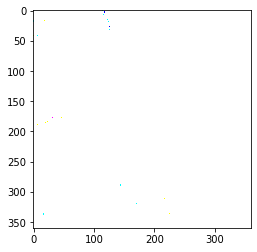

In [0]:
save_path = os.path.join(path_scaled, folder)
save_img_path = os.path.join(save_path, 'pre_' + image_names[2])

# i = PIL.Image.fromarray(im)
# i = PIL.Image.open(img_path)
# i.save(save_img_path)
# plt.imsave(save_img_path, im)

im = (im + 1) * 255/2
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
cv2.imwrite(save_img_path, im)

# im = PIL.Image.fromarray(np.uint8(cm.gist_earth(im)*255))

plt.imshow(im)

In [0]:
os.listdir(save_path)

NameError: ignored

In [0]:
folder = '100'
path_folder = os.path.join(path_train_cropped, folder)
save_path = os.path.join(path_scaled, folder)
image_names = os.listdir(path_folder)
for image_name in image_names:
  img_path = os.path.join(path_folder, image_name)
  im = cv2.imread(img_path)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = preprocess_input(im)
  save_img_path = os.path.join(save_path, 'pre_' + image_name)
  cv2.imwrite(save_img_path, im, )

KeyboardInterrupt: ignored

## Convert to TFLite

In [0]:
# ?tf.saved_model.save

In [0]:
saved_model_dir = path_train_cropped + '/save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(saved_model_dir + '/model-8-MobNet-448.tflite', 'wb') as f:
  f.write(tflite_model)

In [0]:
saved_model_dir

'/content/drive/My Drive/fastai-v3/Indian-Currency-Dataset/train-cropped/save/fine_tuning'

Download the converted model and labels

In [0]:
from google.colab import files

files.download(saved_model_dir + '/model-8-MobNet-448.tflite')
# files.download('labels.txt')